Una serie temporal es un conjunto de muestras tomadas a intervalos de tiempo regulares. Es interesante analizar su comportamiento al mediano y largo plazo, intentando detectar patrones y poder hacer pronósticos de cómo será su comportamiento futuro

* Es dependiente del Tiempo. Esto rompe con el requerimiento que tiene la regresión lineal de que sus observaciones sean independientes.
* Suelen tener algún tipo de estacionalidad, ó de tendencias a crecer ó decrecer.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Importamos las Librerías**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

# Cargar los datos
itapua = pd.read_csv('/content/drive/MyDrive/2. TP Inteligencia Artificial/Itapua/datos_itapua.csv', parse_dates=['fecha'])
caaguazu = pd.read_csv('/content/drive/MyDrive/2. TP Inteligencia Artificial/Caaguazu/datos_caaguazu.csv', parse_dates=['fecha'])
amambay = pd.read_csv('/content/drive/MyDrive/2. TP Inteligencia Artificial/Amambay/datos_amambay.csv', parse_dates=['fecha'])

# Combinar los datos en un solo DataFrame
datos = pd.concat([itapua.assign(departamento='Itapua'),
                   caaguazu.assign(departamento='Caaguazu'),
                   amambay.assign(departamento='Amambay')])

In [3]:
datos.head()

,fecha,peakcurrent,departamento
0,2017-01-01 00:10:14.806118488,-15372.0,Itapua
1,2017-01-01 00:34:07.536481142,10467.0,Itapua
2,2017-01-01 00:41:55.345834017,-27092.0,Itapua
3,2017-01-01 00:47:34.570938110,20780.0,Itapua
4,2017-01-01 00:48:21.808492899,-20842.0,Itapua


In [4]:
datos = datos[(datos['fecha'] >= '2017-01-01') & (datos['fecha'] <= '2018-12-31')]
itapua = itapua[(itapua['fecha'] >= '2017-01-01') & (itapua['fecha'] <= '2018-12-31')]
caaguazu = caaguazu[(caaguazu['fecha'] >= '2017-01-01') & (caaguazu['fecha'] <= '2018-12-31')]
amambay = amambay[(amambay['fecha'] >= '2017-01-01') & (amambay['fecha'] <= '2018-12-31')]

In [5]:
# Convertir la columna de fecha a un índice de fecha/hora
df = datos.set_index('fecha')


In [6]:
# Establecer un límite superior e inferior
límite_inferior = -10000000
límite_superior = 10000000

# Recortar los valores fuera de los límites
df['peakcurrent_recortado'] = df['peakcurrent'].clip(límite_inferior, límite_superior)

# Remuestrear y calcular la media con los valores recortados
df_diario = df['peakcurrent_recortado'].resample('D').mean()

In [7]:
nan = df_diario.isna().sum()
print(nan)


351


In [8]:
df_diario = df_diario.fillna(0)
nan = df_diario.isna().sum()
print(nan)

0


In [9]:
otono2017 = itapua[(itapua['fecha'] >= '2017-03-01') & (itapua['fecha'] <= '2017-06-21')]
#plt.plot(otono2017.values)
otono2018 = itapua[(itapua['fecha'] >= '2018-03-01') & (itapua['fecha'] <= '2018-06-21')]
#plt.plot(otono2018.values)

In [10]:
otono2017

,fecha,peakcurrent
59440,2017-03-01 00:05:13.223707914,26012.0
59441,2017-03-01 00:07:53.518750906,52552.0
59442,2017-03-01 00:07:53.662647009,35701.0
59443,2017-03-01 00:07:53.736741066,37596.0
59444,2017-03-01 13:27:58.284250975,-53213.0
...,...,...
117527,2017-06-08 08:48:28.691738605,10356.0
117528,2017-06-08 08:48:28.981963158,15937.0
117529,2017-06-08 08:49:00.924552679,19078.0
117530,2017-06-08 08:53:14.666400194,13425.0


# **Visualizaciones**

<ipython-input-11-35055da507d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  otono2017['fecha'] = pd.to_datetime(otono2017['fecha'])


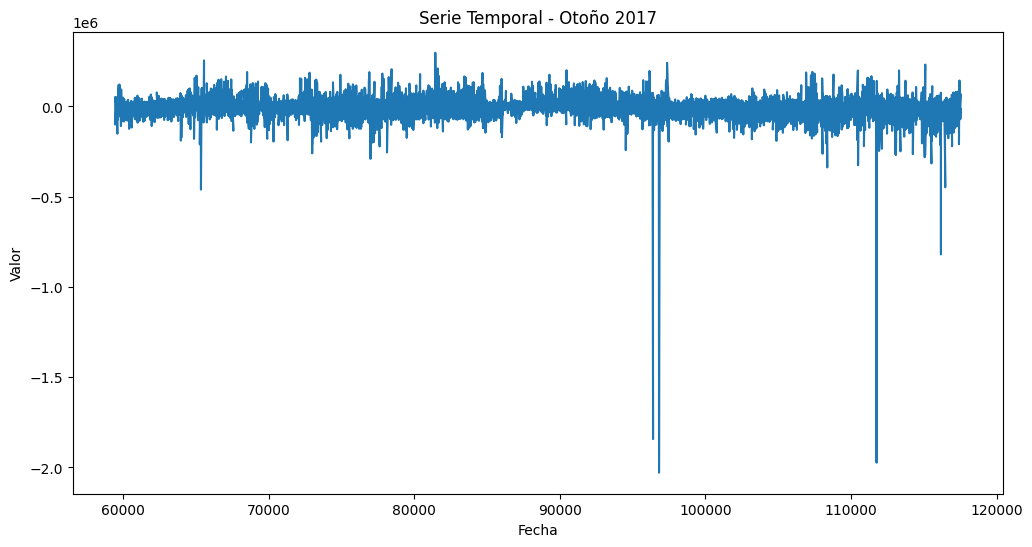

In [11]:
otono2017['fecha'] = pd.to_datetime(otono2017['fecha'])
plt.figure(figsize=(12, 6))
otono2017['peakcurrent'].plot(title='Serie Temporal - Otoño 2017')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.show()

<ipython-input-12-61038b7abc92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  otono2018['fecha'] = pd.to_datetime(otono2018['fecha'])


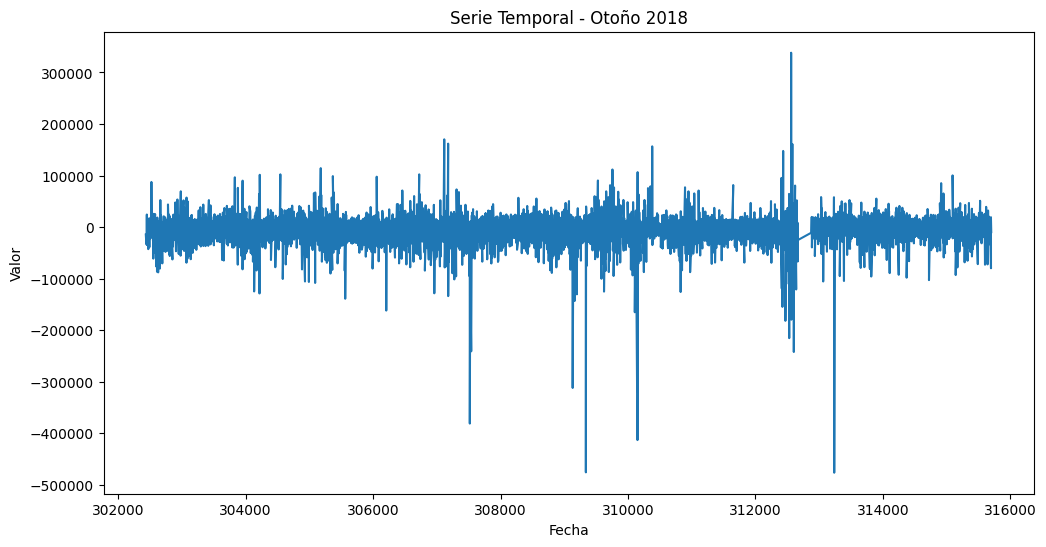

In [12]:
otono2018['fecha'] = pd.to_datetime(otono2018['fecha'])
plt.figure(figsize=(12, 6))
otono2018['peakcurrent'].plot(title='Serie Temporal - Otoño 2018')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.show()

In [13]:
df.drop(columns=['departamento'], inplace=True)

# **Preprocesado de los datos**

Usaremos una arquitectura sencilla de red neuronal FeedForward (también llamada MLP por sus siglas Multi-Layered Perceptron), con pocas neuronas y como método de activación tangente hiperbólica pues entregaremos valores transformados entre -1 y 1.

Tomamos nuestra serie temporal y la convertiremos en un “problema de tipo supervisado“ para poder alimentar nuestra red neuronal y poder entrenarla con backpropagation. Tomar los 7 días previos para “obtener” el octavo

In [14]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

In [15]:
PASOS=7
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    #df.drop(columns=['departamento'], inplace=True)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
values = df_diario.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1)) # MinMaxScaler para transformar el
#rango de nuestros valores entre -1 y 1 (pues sabemos que a nuestra red neuronal,
#le favorece para realizar los cálculos).
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,0.178469,0.025837,0.188520,0.280350,-0.012636,-0.066195,0.150790,-0.115190
8,0.025837,0.188520,0.280350,-0.012636,-0.066195,0.150790,-0.115190,-0.297298
9,0.188520,0.280350,-0.012636,-0.066195,0.150790,-0.115190,-0.297298,0.011670
10,0.280350,-0.012636,-0.066195,0.150790,-0.115190,-0.297298,0.011670,0.161647
11,-0.012636,-0.066195,0.150790,-0.115190,-0.297298,0.011670,0.161647,0.137016


In [16]:
reframed.shape

(722, 8)

# **Dividimos en set de Entrenamiento y Validación**

In [17]:
# split into train and test sets
values = reframed.values
n_train_days = 580- (5+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(568, 1, 7) (568,) (154, 1, 7) (154,)


# **Creamos el Modelo de Red Neuronal**

In [18]:
def crear_modeloFF():
    model = Sequential()
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

# **Entrenamos**

In [19]:
EPOCHS=20

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 7)              56        
                                                                 
 flatten (Flatten)           (None, 7)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 8         
                                                                 
Total params: 64 (256.00 Byte)
Trainable params: 64 (256.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
82/82 [==============================] - 2s 15ms/step - loss: 0.1970 - mse: 0.0730 - val_loss: 0.1072 - val_mse: 0.0258
Epoch 2/20
82/82 [==============================] - 0s 5ms/step - loss: 0.1661 - mse: 0.0579 - val_loss: 0.0921 - val_mse: 0.0217
Epoch 3/20
82/82 [=====

5/5 [==============================] - 0s 3ms/step


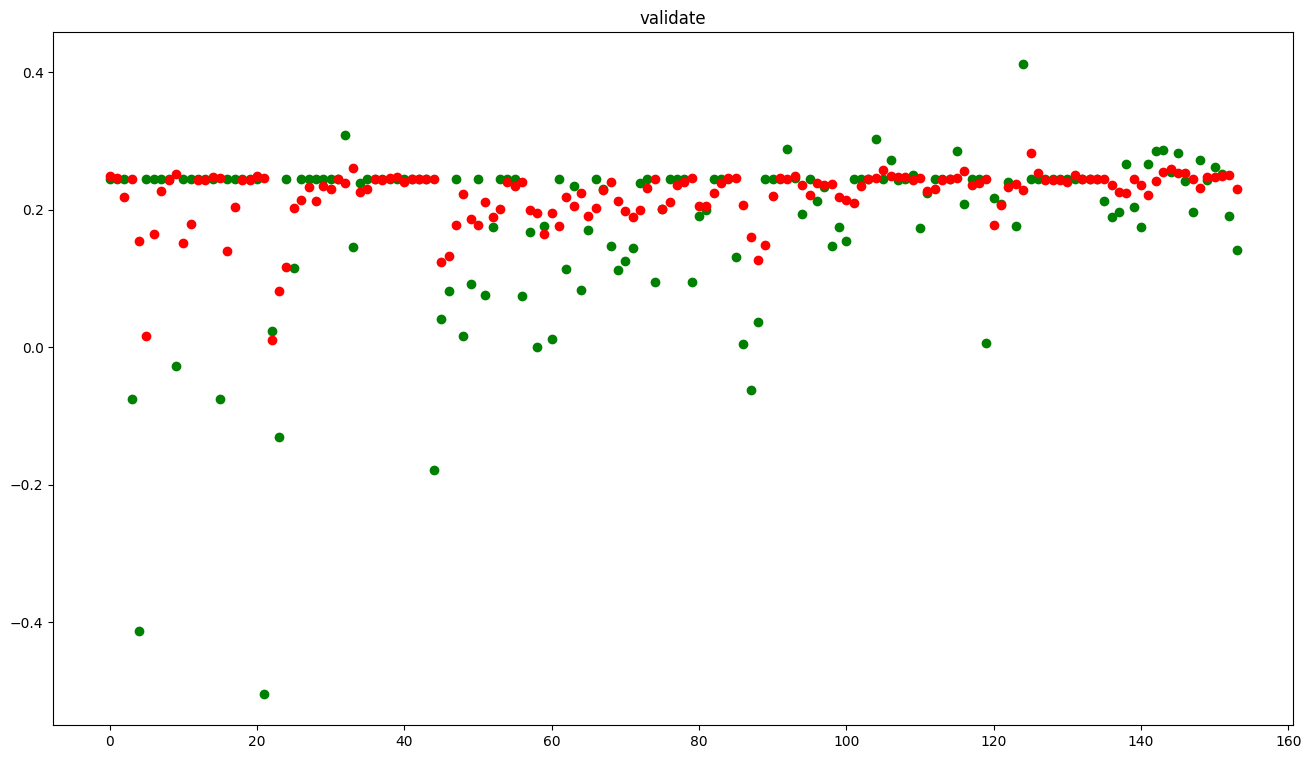

In [20]:
results=model.predict(x_val)
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

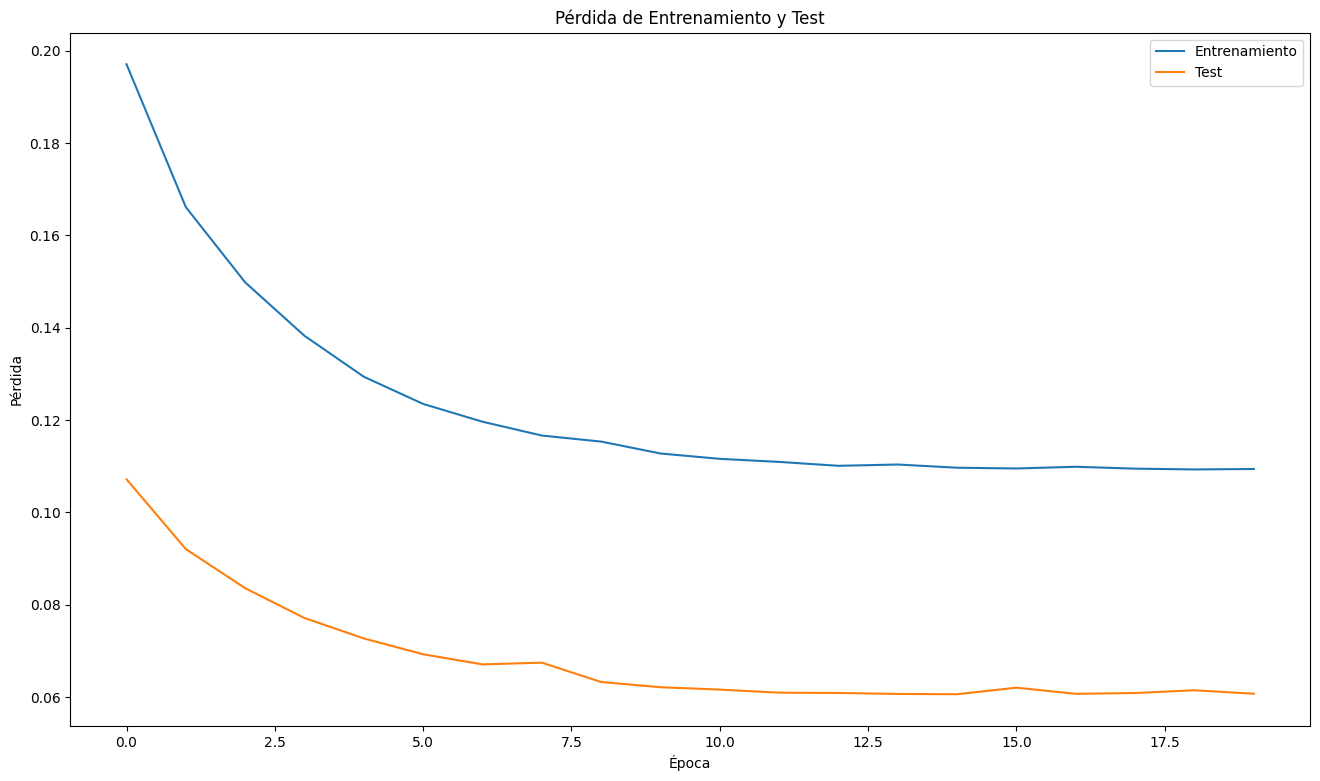

In [21]:
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Test')

# Etiquetas y título del gráfico
plt.title('Pérdida de Entrenamiento y Test')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()  # Muestra la leyenda con las etiquetas
plt.show()


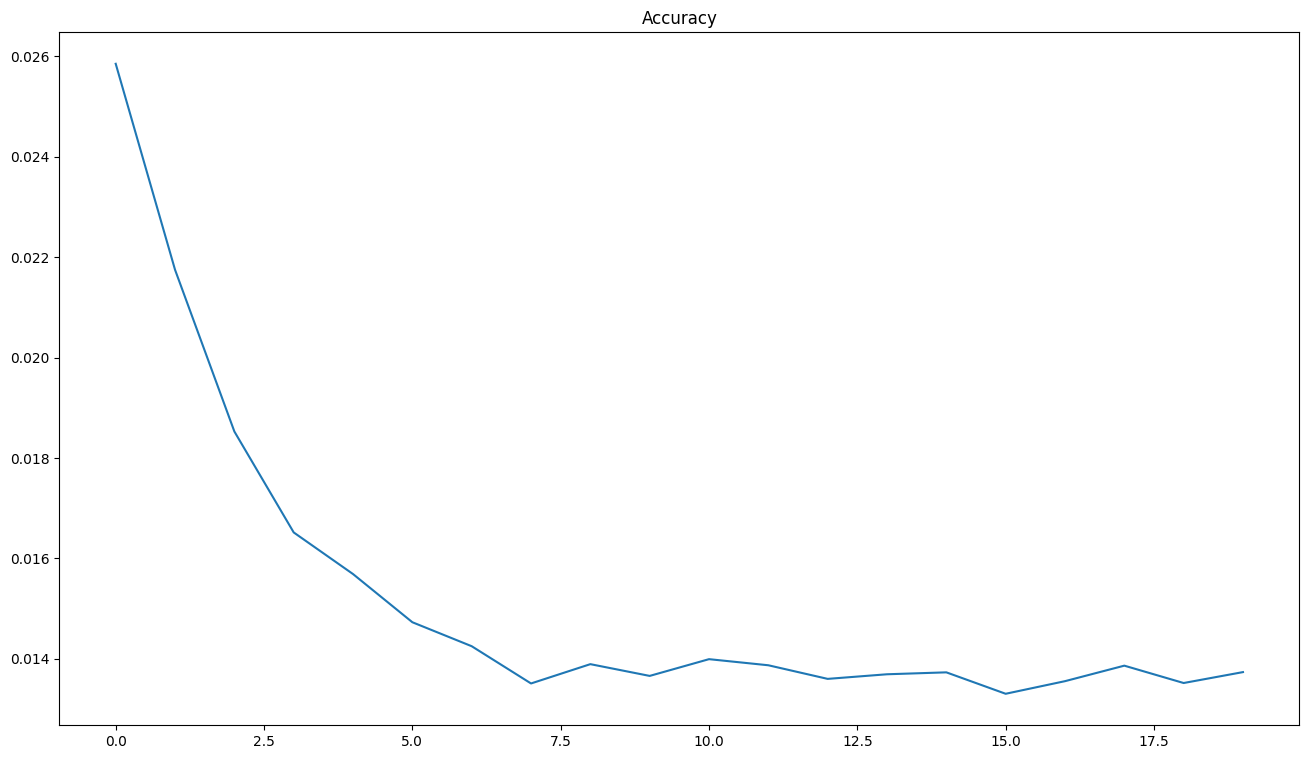

In [22]:
plt.title('Accuracy')
plt.plot(history.history['val_mse'])
plt.show()

In [23]:
import numpy as np
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(400)

,real,prediccion,diferencia
0,0.000000,199.626389,-199.626389
1,0.000000,31.436295,-31.436295
2,0.000000,-1215.936279,1215.936279
3,-14831.833008,-27.263056,-14804.570312
4,-30389.833984,-4194.550781,-26195.283203
...,...,...,...
149,-121.567810,92.863190,-214.431000
150,772.149841,128.724686,643.425171
151,282.824768,156.988708,125.836060
152,-2506.005615,232.653641,-2738.659180


<Axes: >

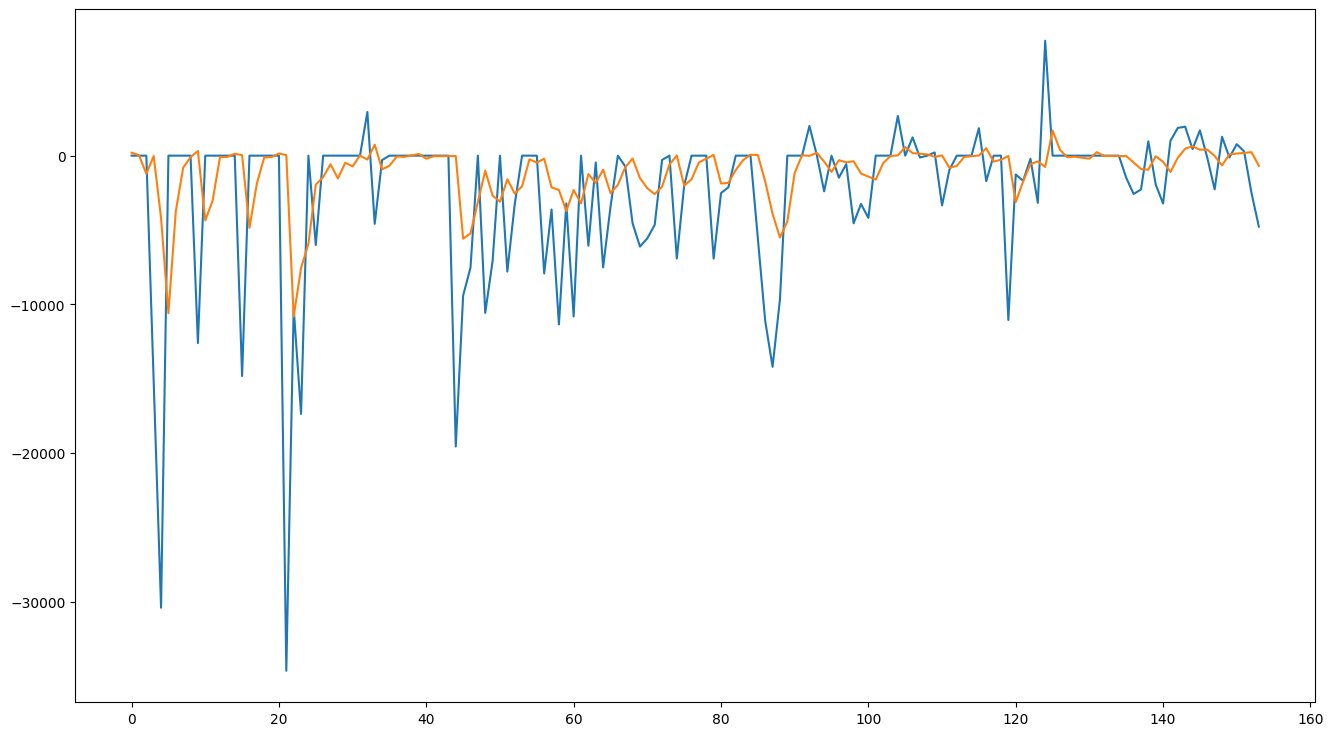

In [24]:
compara2['real'].plot()
compara2['prediccion'].plot()

# **Conteo de fechas por departamento**

In [25]:
caaguazu['fecha'] = pd.to_datetime(caaguazu['fecha'])

# Extraer año, mes y día
caaguazu['año'] = caaguazu['fecha'].dt.year
caaguazu['mes'] = caaguazu['fecha'].dt.month
caaguazu['dia'] = caaguazu['fecha'].dt.day

# Agrupar por año, mes y día, y contar ocurrencias
caaguazu = caaguazu.join(caaguazu.groupby(['año', 'mes', 'dia'])['fecha'].size().rename('conteo_fechas'), on=['año', 'mes', 'dia'])
caaguazu['departamento'] = 'Caaguazú'

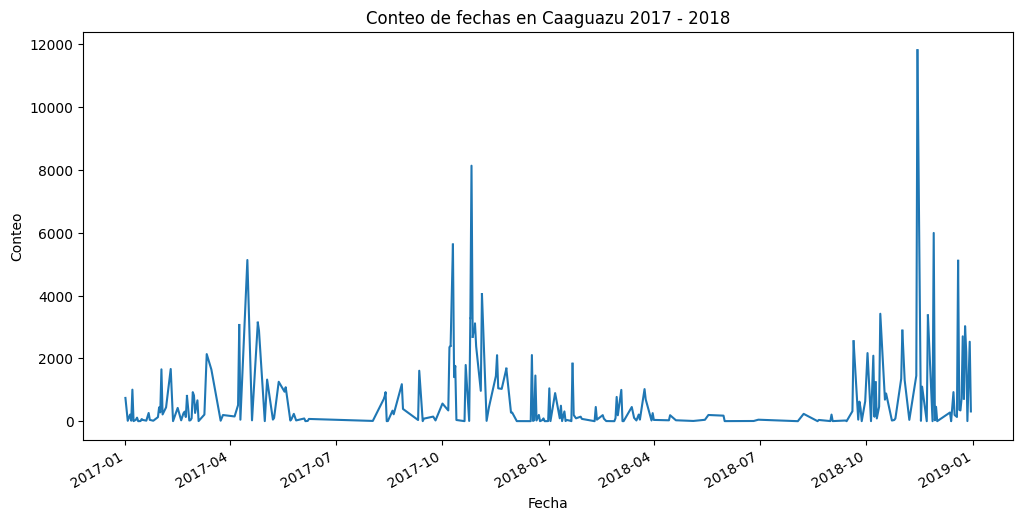

In [26]:
# Combinar año, mes y día en una sola columna de fecha
caaguazu['fecha'] = pd.to_datetime(caaguazu['año'].astype(str) + '-' + caaguazu['mes'].astype(str) + '-' + caaguazu['dia'].astype(str))

# Establecer la columna 'fecha' como índice
caaguazu = caaguazu.set_index('fecha')

# Graficar el conteo como una serie temporal
caaguazu['conteo_fechas'].plot(figsize=(12, 6))
plt.xlabel('Fecha')
plt.ylabel('Conteo')
plt.title('Conteo de fechas en Caaguazu 2017 - 2018')
plt.show()

In [27]:
itapua['fecha'] = pd.to_datetime(itapua['fecha'])

# Extraer año, mes y día
itapua['año'] = itapua['fecha'].dt.year
itapua['mes'] = itapua['fecha'].dt.month
itapua['dia'] = itapua['fecha'].dt.day

# Agrupar por año, mes y día, y contar ocurrencias
itapua = itapua.join(itapua.groupby(['año', 'mes', 'dia'])['fecha'].size().rename('conteo_fechas'), on=['año', 'mes', 'dia'])
itapua['departamento'] = 'Itapuá'

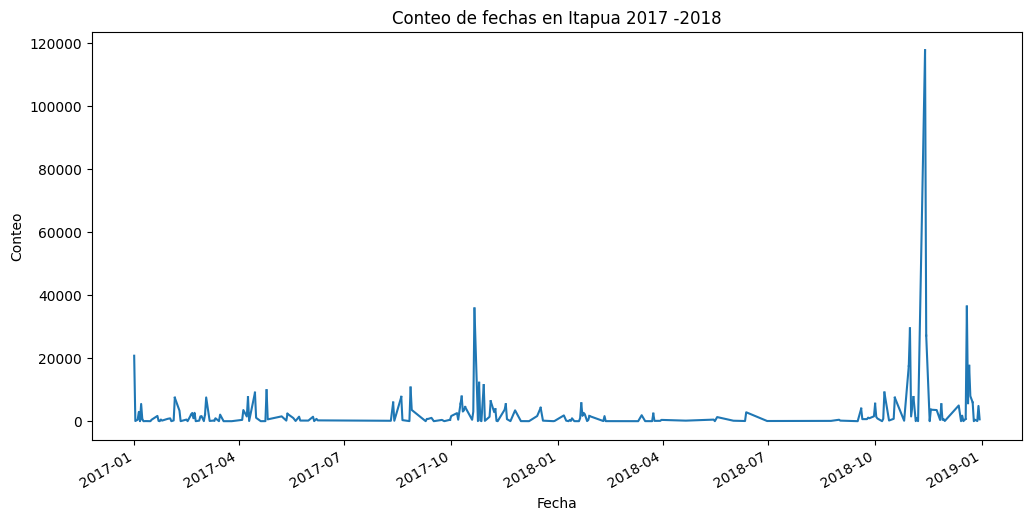

In [28]:
# Combinar año, mes y día en una sola columna de fecha
itapua['fecha'] = pd.to_datetime(itapua['año'].astype(str) + '-' + itapua['mes'].astype(str) + '-' + itapua['dia'].astype(str))

# Establecer la columna 'fecha' como índice
itapua = itapua.set_index('fecha')

# Graficar el conteo como una serie temporal
itapua['conteo_fechas'].plot(figsize=(12, 6))
plt.xlabel('Fecha')
plt.ylabel('Conteo')
plt.title('Conteo de fechas en Itapua 2017 -2018')
plt.show()

In [29]:
amambay['fecha'] = pd.to_datetime(amambay['fecha'])

# Extraer año, mes y día
amambay['año'] = amambay['fecha'].dt.year
amambay['mes'] = amambay['fecha'].dt.month
amambay['dia'] = amambay['fecha'].dt.day

# Agrupar por año, mes y día, y contar ocurrencias
amambay = amambay.join(amambay.groupby(['año', 'mes', 'dia'])['fecha'].size().rename('conteo_fechas'), on=['año', 'mes', 'dia'])
amambay['departamento'] = 'Amambay'

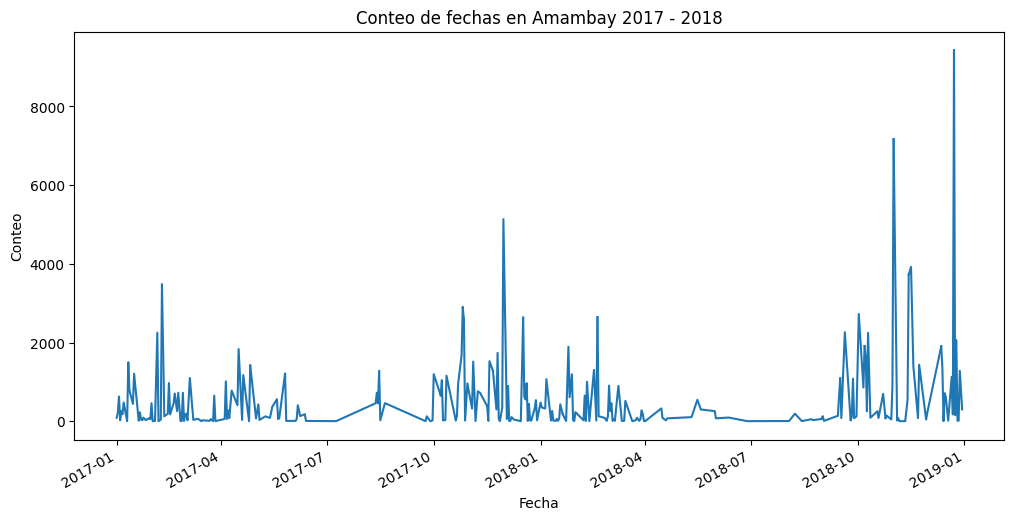

In [30]:
# Combinar año, mes y día en una sola columna de fecha
amambay['fecha'] = pd.to_datetime(amambay['año'].astype(str) + '-' + amambay['mes'].astype(str) + '-' + amambay['dia'].astype(str))

# Establecer la columna 'fecha' como índice
amambay = amambay.set_index('fecha')

# Graficar el conteo como una serie temporal
amambay['conteo_fechas'].plot(figsize=(12, 6))
plt.xlabel('Fecha')
plt.ylabel('Conteo')
plt.title('Conteo de fechas en Amambay 2017 - 2018')
plt.show()

In [31]:
caaguazu.head()

,peakcurrent,año,mes,dia,conteo_fechas,departamento
fecha,,,,,,
2017-02-05,6378.0,2017,2,5,441,Caaguazú
2017-10-29,8422.0,2017,10,29,3115,Caaguazú
2017-10-29,-10163.0,2017,10,29,3115,Caaguazú
2017-01-01,16648.0,2017,1,1,741,Caaguazú
2017-10-08,12604.0,2017,10,8,2398,Caaguazú


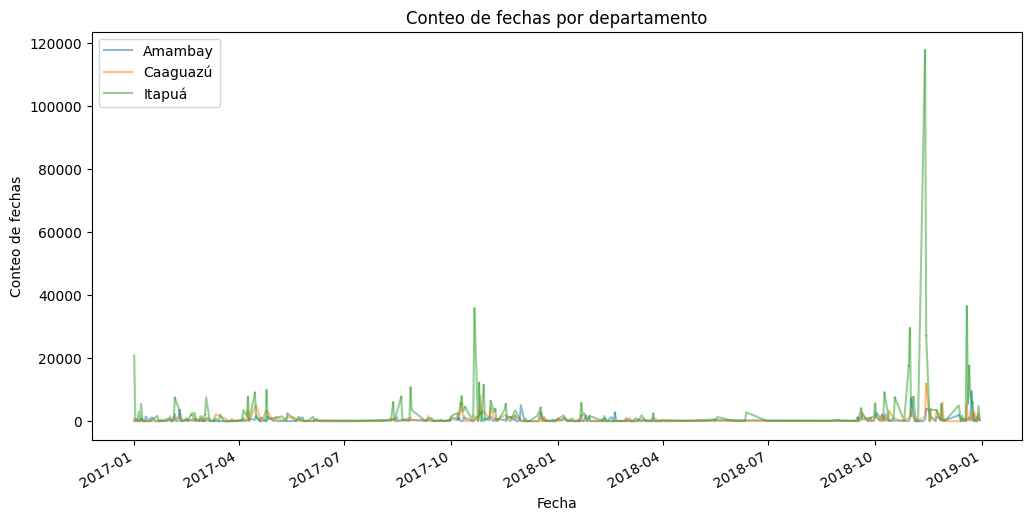

In [32]:
# Combinar los tres DataFrames
todos_departamentos = pd.concat([caaguazu, itapua, amambay])

# Graficar los conteos de cada departamento
plt.figure(figsize=(12, 6))
for departamento, grupo in todos_departamentos.groupby('departamento'):
    grupo['conteo_fechas'].plot(label=departamento, alpha=0.5)

plt.xlabel('Fecha')
plt.ylabel('Conteo de fechas')
plt.title('Conteo de fechas por departamento')
plt.legend()
plt.show()

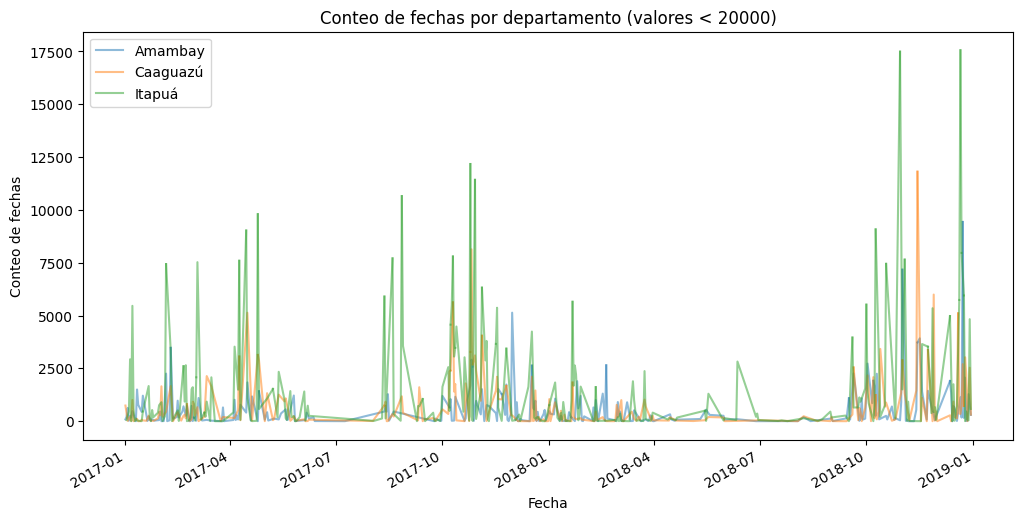

In [33]:
# Filtrar los valores de conteo_fechas menores a 20000
menores_20000 = todos_departamentos[todos_departamentos['conteo_fechas'] < 20000]

# Graficar los conteos de cada departamento
plt.figure(figsize=(12, 6))
for departamento, grupo in menores_20000.groupby('departamento'):
    grupo['conteo_fechas'].plot(label=departamento, alpha=0.5)

plt.xlabel('Fecha')
plt.ylabel('Conteo de fechas')
plt.title('Conteo de fechas por departamento (valores < 20000)')
plt.legend()
plt.show()

In [ ]:
#@title Convert ipynb to HTML in Colab
# Upload ipynb
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")